# MODFLOW6 modeling with FloPy (Steady State)

In this notebook, we will introduce the new modularization concepts of MODFLOW6 and demonstrate how the FloPy interface can be used to create, run, and visualize results from a basic model. In the process, we'll see how interaction between FloPy and MODFLOW6 differs from interactions with pre-MODFLOW6 models.

## Learning Objectives

After you have read and run this notebook, you should be able to:
* Describe the modular structure used in MODFLOW6, and the necessary inputs to create a well-defined steady-state model.
* Apply FloPy utilities to visualize, debug, and verify MODFLOW6 model inputs.
* Create a complete set of input files needed for a MODFLOW6 model to run successfully.
* Use data extraction and post-processing routines to visualize model results and apply "hydrosense"

## Initial Setup

For this notebook, we will import flopy and also define shortcuts to the `flopy.discretization` module as `fpd`.

To simplify plotting later in the notebook, we also define a function `combined_gridplot` which produces both a cross-section and map view of the model area, similar to what is viewable in Groundwater Vistas. The function returns handles to the figure object, subplot axes objects, and graphics objects so that you can further modify the plots with later commands. As you go through the class, you may consider using `combined_gridplot` as a template to build more sophisticated visualizations of your model grid.

In [1]:
import flopy
import flopy.utils as fpu
import flopy.discretization as fpd

#TODO: I'd prefer not to do this. Why doesn't explicit work?
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen

import numpy as np
import matplotlib.pyplot as plt
import os

def combined_gridplot(modelgrid_in,cross_type="row", cross_num=0,vert_exag=1):
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5,5),height_ratios=[0.2,1])

    try:
        axs[0].set_aspect(vert_exag)
        pcr = flopy.plot.PlotCrossSection(modelgrid=modelgrid_in, ax=axs[0], line={cross_type: cross_num}, geographic_coords=True)
        pcr.plot_grid(lw=0.5)
        if cross_type=="row":
            axs[0].set_xlabel('x')
        elif cross_type=="column":
            axs[0].set_xlabel('y')
        axs[0].set_ylabel('z')
        axs[0].set_title(f'Cross-section through {cross_type} {cross_num}, Vertical Exag = {vert_exag}')
    except:
        print('Cross-section could not be generated. Check inputs')
        pcr = None
    
    axs[1].set_aspect(1)
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid_in, ax=axs[1])
    pmv.plot_grid(lw=0.5)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title(modelgrid_in)
    return fig, axs, [pcr, pmv]


# Building the model inputs with FloPy 

## Step 1: Create the simulation object and associated Solver and Timing module inputs

A first key difference between MODFLOW 6 and other versions of MODFLOW is that it is designed around the paradigm of connecting multiple models together. At the highest level, a `simulation` object defines the set of models that will be run by MODFLOW6. This simulation object can contain multiple models, coupled via "exchanges" between individual models. The simulation - including all models contained within it - is solved by a defined solver (currently the Iterative Model Solution (IMS) module is the only one supported). In addition, all models use a consistent time discretization which is specified by the Time Discretization (TDIS) module.

Beneath the simulation object, one or a series of models is created and coupled to other models via model exchanges. The model can be for simulating Groundwater Flow (GWF), or - more recently - other processes such as solute transport via the Groundwater Transport (GWT) model, or transport of energy via the Groundwater Energy (GWE) model. Each model contains its own packages for simulating different stresses.

The generalized heirarchy for MODFLOW 6 is thus:
* **Simulation** (Top level object), which contains
    * Solver module used
    * Timing module used
    * An **exchange object** for defining exchange (of water in this case) between multiple models
    * One or more **models**, with associated package inputs for example:
    * 1. A GWF model, containing:
        * A discretization package for the model
        * Stress packages for the model
    * 2. A second GWF model, containing:
        * A discretization package for the model
        * Stress packages for the model

(Note that below, our first MODFLOW 6 model will consist of only a single model, therefore no model exchanges need to be defined.)

Because MODFLOW6 is so different from pre-MODFLOW6 implementations, the methods for interacting with MODFLOW are contained in a different set of subpackages within FloPy. To interact with pre-MODFLOW6 models, we used `flopy.modflow` and associated subpackages. With MODFLOW6 models, we use `flopy.mf6`.

In [2]:
#We will put the model files in a subdirectory under our "models" directory.
#The model_nm variable sets the filenames for all package inputs
model_dir = os.path.join('.','models','mf6init')
model_nm = "mf6init"

#STEP 1: CREATE THE SIMULATION OBJECT AS WELL AS THE SOLVER (IMS) OBJECT
#AND TIME DISCRETIZATION (TDIS) OBJECT
sim = flopy.mf6.MFSimulation(sim_name=model_nm, sim_ws=model_dir)
tdis = flopy.mf6.ModflowTdis(sim,time_units="days")

## Step 2: Defining the Groundwater Flow (GWF) model and discretization

It is possible to create discretization information directly after creating a Groundwater Flow (GWF) model directly. For MODFLOW6, there are three options for GWF model grids, including "standard" rectangular grids (DIS), discretization by vertices (DISV), and fully unstructured grids (DISU). These grids can be created directly by inputs to `flopy.mf6.ModflowGwfdis`, `flopy.mf6.ModflowGwfdisv` and `flopy.mf6.ModflowGwfdisu`, respectively, but again doing so is **strongly discouraged!**. 

Instead, FloPy's discretization module provides a consistent way to create and store information about Structured, Vertex-based , and Unstructured grids. **It is always a good idea** to use `flopy.discretization` first to create a separate modelgrid object. 


Grid Valid   :  True
Grid Complete:  True


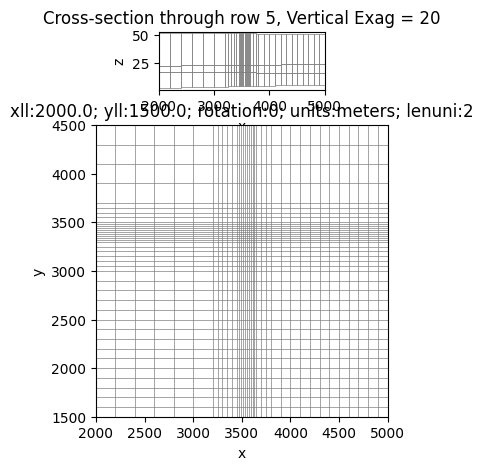

In [3]:
#STEP 2A: CREATE THE MODELGRID OBJECT

#User definition of the grid boundaries and setup, from earlier.
xb = np.concatenate((np.arange(2000,3200,200), 
                    np.arange(3200,3450,50), 
                    np.arange(3450,3650,20), 
                    np.arange(3650,3800,50),
                    np.arange(3800,5000+.1,100)),0)
yb = np.concatenate((np.arange(1500,3000,100),
                     np.arange(3000,3300,50),
                     np.arange(3300,3500,20),
                     np.arange(3500,3700,50),
                     np.arange(3700,4500+.1,200)),0)[::-1]
xm = (xb[0:(len(xb)-1)] + xb[1:(len(xb))])/2
ym = (yb[0:(len(yb)-1)] + yb[1:(len(yb))])/2
xmg, ymg = np.meshgrid(xm,ym)

#Define units for the numbers above
units = 'm'

#Define some sloping planes based on functions evaluated at cell center coordinates
top = 50 - 0.0005*(xmg - 2000) + 0.001*(ymg - 1500)
botmlay0 = 20 + 0.0005*(xmg - 2000) + 0.001*(ymg - 1500)
botmlay1 = 19 - 0.0005*(xmg - 2000) - 0.001*(ymg - 1500)
botmlay2 = 0 + 0.001*(xmg - 2000) + 0.001*(ymg - 1500)

#Calculate the inputs, in MODFLOW / FloPy-speak
#find lower-left x coordinate, and calculate step size, left to right
xoff = xb[0]
delr = np.diff(xb)
ncol = delr.shape[0]
#find lower-left coordinate, and calculate step size from top to bottom
yoff = yb[-1]
delc = -np.diff(yb)
nrow = delc.shape[0]

botm = np.stack((botmlay0,botmlay1, botmlay2),0)
nlay = botm.shape[0]
ibound = np.ones((nlay, nrow, ncol))

modelgrid = fpd.StructuredGrid(
    delc=delc,
    delr=delr,
    top=top,
    botm=botm,
    idomain=ibound,
    xoff=xoff,
    yoff=yoff,
    lenuni=units,
    angrot=0,
)

print('Grid Valid   : ',modelgrid.is_valid)
print('Grid Complete: ',modelgrid.is_complete)

#Plot using our built-in function
fig, axs, plots = combined_gridplot(modelgrid,cross_type="row",cross_num=5,vert_exag=20)

In [4]:
#STEP 2B: CREATE THE GWF OBJECT, AND ADD A DIS PACKAGE BY APPLYING PROPERTIES
#FROM THE MODELGRID OBJECT

gwf = flopy.mf6.ModflowGwf(sim, modelname=model_nm)

dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=modelgrid.units,
    xorigin=modelgrid.xoffset,
    yorigin=modelgrid.yoffset,
    angrot=modelgrid.angrot,
    nlay=modelgrid.nlay,
    nrow=modelgrid.nrow,
    ncol=modelgrid.ncol,
    top=modelgrid.top,
    botm=modelgrid.botm,
    delc=modelgrid.delc,
    delr=modelgrid.delr,
)

## Step 3: Defining hydraulic properties for the aquifer

Only one **"Flow Package"** is available in MODFLOW6, which is the Node Property Flow (NPF) package.

Properties that are supplied within flow packages include:
* Hydraulic conductivity $K [L/T]$, and associated anisotropy information

As a key difference from earlier MODFLOW versions, the storage properties of the aquifer are specified in a different **Storage Package** (STO). The STO package contains:
* Specific Yield ($S_y$) information for the model
* Specific storage ($S_s$) information for the model
* A flag indicating whether each stress period should be treated as steady-state or transient.

Again, at early stages of developing a model, it is good practice to **use FloPy's built-in plotting and error-checking routines for each package** to ensure that inputs are reasonable.

In [5]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    k=[100,1,5],
    k22=[100,1,5],
    k33=[50,0.1,0.5],
    )

# Since the model is steady-state, no storage package needs to be supplied. However, it would look like this:)
#sto = flopy.mf6.ModflowGwfsto(
#    gwf,ss=1e-5, sy=0.1,steady_state={0:True})

#Use the below to verify that "interpreted" / default inputs are OK
#npf.plot()
#npf.check()

## Step 4: Defining stress package inputs

Stress packages are used to define any "hydraulic stress" on the aquifer that influences how groundwater moves. If it might act as a source of water to an aquifer, pull water out of an aquifer, or move water from one place to another within an aquifer, it's a stress. 

The least-complex stress packages to use are:
* CHD (Constant Head) Package
* FHB (Flow and Head Boundary) Package
* GHB (General Head Boundary) Package
* RCH (Recharge) Package
* WEL (Well) Package
* DRN (Drain) Package
* RIV (River) Package

**Each stress package has its own format and type of inputs**, and figuring out what each of the inputs mean (and how the model wants them supplied) is one of the steeper learning curves for MODFLOW. For example, since recharge tends to occur everywhere over an aquifer, the RCH package uses inputs that are the shape of the map-view model grid - an array with size `nrow` by `ncol`. In contrast, wells are usually closer to "points" in space, and so the WEL package wants to know about the specific grid cell where a well is located and the pumping rate, i.e. 3 values per well. Inputs will also get more complex for transient models, as they are specified per "stress period" in the model. 

Like with the flow package, FloPy will often choose reasonable default values if you don't specify all inputs to a stress package.
**Using Shift-tab within each FloPy definition is a good way to learn about the inputs for each stress package, and what defaults will be applied**.

In this code example, we demonstrate an over-simplified case where the grid-based location (row / column) of a well is specified, and other stresses are nicely oriented on the model grid (e.g., the river is exactly one column of the model). A better approach is to **develop a database of model stresses that are grid-independent**, and to then pull them onto the model grid. However, this requires further background in GIS and other utilities and so we'll reserve that for a future notebook.

In [6]:
riv_spd = {0: [[0, i, (modelgrid.ncol-1), 49.5, modelgrid.delc[i]*5, 49] for i in range(modelgrid.nrow)]}
#Note - the below will create a non-physical solution unless a regular grid is used, 
#since the conductance should depend on length x width
#riv_spd = {0: [[0, i, (modelgrid.ncol-1), 49.5, 40, 49] for i in range(modelgrid.nrow)]}

riv = flopy.mf6.ModflowGwfriv(
    gwf,stress_period_data=riv_spd
)

rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=0.001)

wel = flopy.mf6.ModflowGwfwel(gwf,stress_period_data={0: [2, 15, 15, -50]})

## Step 5: Define Numerical (Solver Package) Inputs

Finally, a solver package must be specified which determines how MODFLOW will approach the matrix-vector system of equations that are generated, and output control is used to specify how and where model outputs will be generated.

The user can choose **one solver package**. Currently the only solver package supported in MODFLOW6 is the Iterative Model Solution (IMS) package.

In addition, the user must specify an initial condition via the IC package. In the case of steady-state models, the key purpose of the initial condition is to specify the initial guess that's used during iteration.

In [7]:
ims = flopy.mf6.ModflowIms(sim, complexity="COMPLEX")
ic = flopy.mf6.ModflowGwfic(gwf, strt=320.0)

# Step 6: Setup output specifications

Finally, we set the name to be used for the output of the head and budget files. Especially when debugging models, having the budget files provides a useful way to check the accuracy of the numerical iteration.

In [8]:
hname = f"{model_nm}.hds"
cname = f"{model_nm}.cbc"
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=cname,
    head_filerecord=hname,
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

#This sets it up so that all packages save their flows as part of the budget file.
gwf.name_file.save_flows = True

## Step 7: Write the input files and run MODFLOW

This is the place where all of your hard work has paid off. If you have carefully specified your inputs and used the available debugging / plotting tools, your model should run successfully with two lines of code!

If `success = True`, you are "done".

If (when) your model doesn't run successfully, remember the following approaches:
* Carefully investigate each of the package inputs using the package objects' `.plot()` and `.check()` routines
* Review the `.list` file that is output when MODFLOW runs.

In [9]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6init...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 39 based on size of stress_period_data
    writing package rcha_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package ic...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../../opt/anaconda3/envs/geosci724/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

        MODFLOW 6 compiled Dec 23 2024 16:29:44 with GCC version 12.4.0

This software has been approved for release by the U.S. G

(True, [])

## Step 7-$\infty$: Processing your results to and changing your model to make it "less wrong"

Even if your model does run, **be skeptical - there is no replacement for hydrosense**. You should have a reasonable expectation of what your results will look like, and whether the output passes the "sniff test".

Remember the old mantra: **all models are wrong** (at least in some way). The job of the good modeler is to know how to test a model well and understand what parts of the model are trustworthy vs. where simplifications or unjustified assumptions have a significant impact on results.

There are many, many ways to stress-test and improve your model. A non-exhaustive list:
* Ensure that your model mass balance is reasonable. Mass should not be created or destroyed.
* Make sure that your model isn't dependent on artificial computational definitions *Example: You get a totally different result when implementing a different solver, or changing solution tolerances, or changing your stress periods*
* Make sure you haven't set (known) values incorrectly. *Example: $S_y = 2$*
* Consider how strongly your model results are impacted by set (uncertain) values. *Example: What if you're wrong about riverbed conductance values?*
* Consider whether unmodeled processes may be important to your results. *Example: How much aquifer compaction might affect these results? What about variable density of water?*

In [10]:
hobj = gwf.output.head()
hds = hobj.get_data()
cobj = gwf.output.budget()
#TODO: This doesn't work, come back to it
#spd = cobj.get_data(text="DATA-SPDIS")[0]

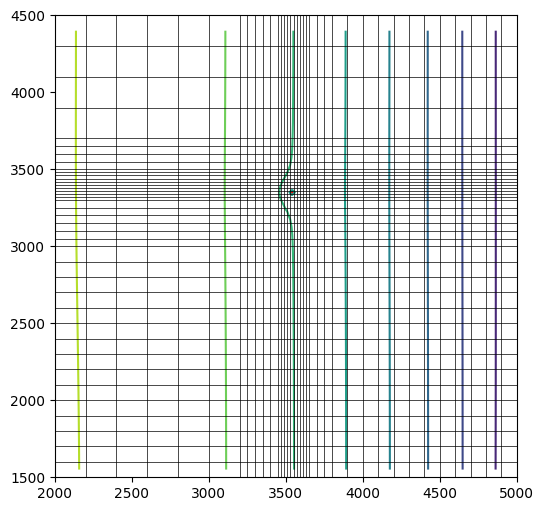

In [11]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1, 1, 1, aspect="equal")

mm = flopy.plot.PlotMapView(model=gwf, layer=2, extent=gwf.modelgrid.extent,ax=ax1)
cbv = mm.contour_array(hds)
#q = mm.plot_vector(spd["qx"], spd["qy"])
mm.plot_bc("RIV", color="blue")
mm.plot_bc("WEL", plotAll=True)
mm.plot_grid(lw=0.5, color="black")


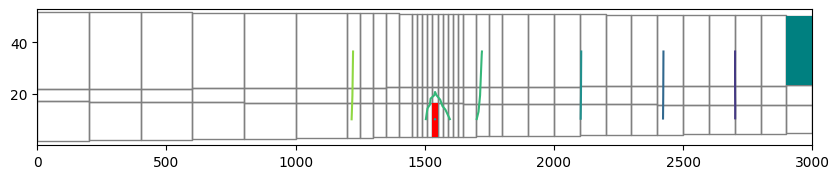

In [12]:
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(1, 1, 1, aspect=10)
modelcr = flopy.plot.PlotCrossSection(model=gwf,line={"row":15},ax=ax2)
modelcr.plot_ibound()
modelcr.plot_grid()
modelcr.plot_bc(name="RIV")
modelcr.plot_bc(name="WEL")
modelcr.contour_array(hds)
